# Income Classification Analysis using a Multilayer Perceptron

This Jupyter Notebook explores the UCI Adult Income dataset, which is designed to predict whether individuals earn more than $50,000 per year based on census data. The analysis includes a comprehensive approach, incorporating data preprocessing, exploratory data analysis (EDA), model training, and evaluation. The goal is to build and refine predictive models that can accurately classify individuals into income categories.

## Overview of the Notebook

1. **Data Preparation:** Initially, we load the data and conduct preliminary data cleaning. This includes handling missing values and categorizing features as either continuous or categorical for subsequent processing.

2. **Exploratory Data Analysis (EDA):** We perform EDA to gain insights into the data distribution and relationships between features. This involves visualizing distributions and correlations to better understand the data's characteristics.

3. **PCA Visualization:** We apply dimensionality reduction techniques to visualize the data in two-dimensional space, helping us understand the separability of income classes post-modeling.

4. **Feature Engineering:** We encode categorical variables and scale continuous features to prepare them for model input. This preprocessing step is crucial for effective model performance.

5. **Data Splitting:** The dataset is split into training, validation, and test sets to ensure the model can be trained, validated, and tested on independent data segments.

6. **Oversampling Techniques:** To address class imbalance in the dataset, we apply oversampling methods like SMOTE and Random Oversampler specifically to the training data. This helps in preventing the model from being biased towards the majority class.

7. **Model Building:** We define a MLP model using PyTorch for classification. Additionally, we compare its performance with traditional machine learning models—Logistic Regression and Random Forest—to establish benchmarks.

8. **Model Training and Early Stopping:** The MLP is trained with considerations for overfitting. We incorporate an early stopping mechanism that monitors the validation loss and stops training when the model ceases to improve, thereby saving the best model state.

9. **Evaluation:** Finally, we assess the model's performance on the validation and test datasets using metrics such as accuracy and F1 score and we compare it with the traditional machine learning models. We also visualize the results to provide clear, interpretable outcomes of the model's performance.



In [ ]:
# Import and install necessary libraries
!pip install torchsummary
!pip install imblearn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 2.5 MB/s eta 0:00:00


In this cell we load the Adult dataset from the UCI Machine Learning Repository. Details about the dataset can be found at [https://archive.ics.uci.edu/dataset/2/adult](https://archive.ics.uci.edu/dataset/2/adult). This dataset is commonly used to predict whether income exceeds $50K/yr based on census data. We start by reading the data into a DataFrame, displaying its initial shape, and handling missing values. We then categorize the features into 'categorical' and 'continuous' types for future preprocessing steps.


In [ ]:
#IMPORT AND PREPARE DATA

#read data into pandas dataframe
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
data = pd.read_csv(url, names=columns, na_values="?", skipinitialspace=True)
print(data.shape)

# Drop missing values
data.dropna(inplace=True)
print(data.shape)

# Separate categorical and continuous features
categorical_features = [col for col in data.columns if data[col].dtype == "object"]
continuous_features = [col for col in data.columns if col not in categorical_features]

(32561, 15)
(30162, 15)


This block is dedicated to exploratory data analysis (EDA). EDA is crucial to understand the underlying patterns and anomalies in the data. We use histograms to visualize the distribution of continuous features and count plots for categorical features, providing insights into the dataset's structure and composition. We also compute and visualize the correlation matrix to identify potential relationships between features.


Histograms for continuous features



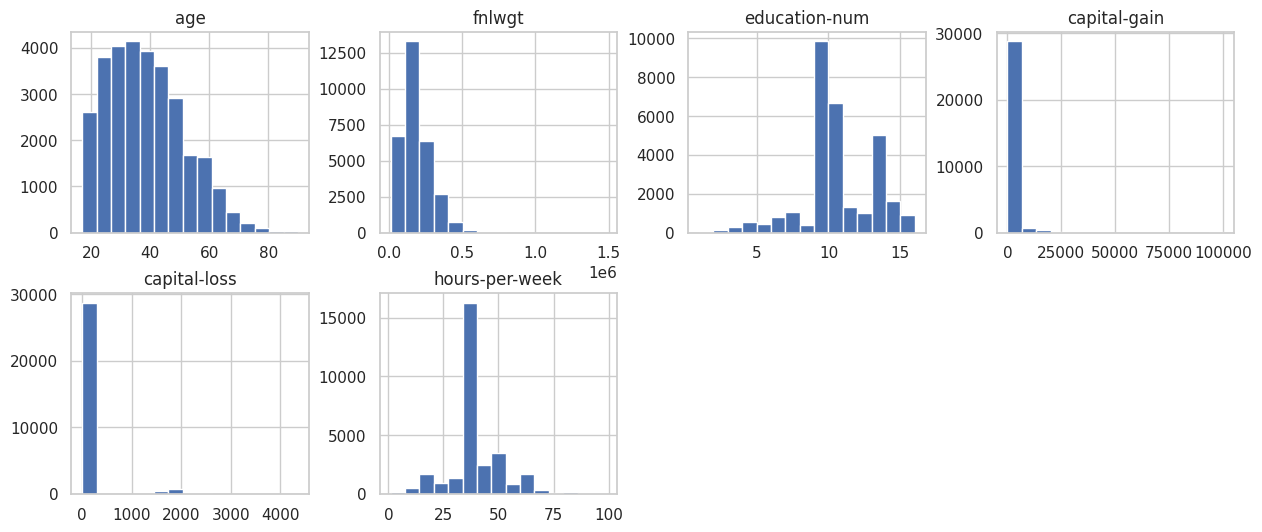

Count plots for categorical features



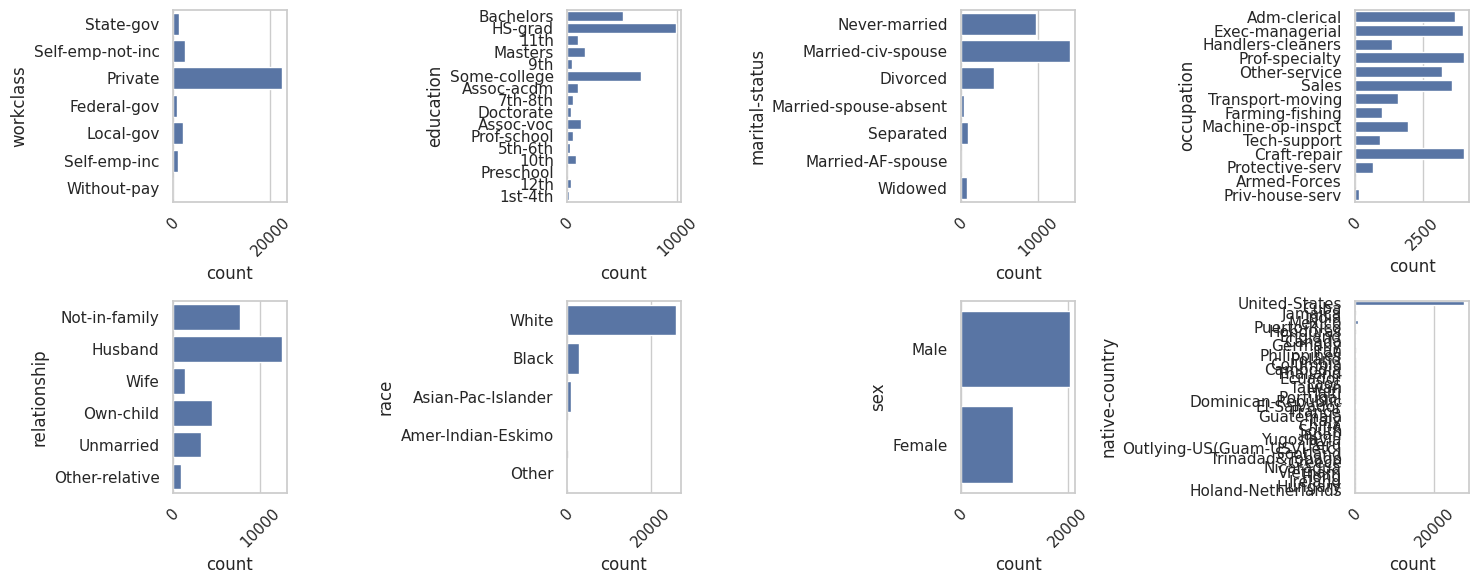

Correlation matrix



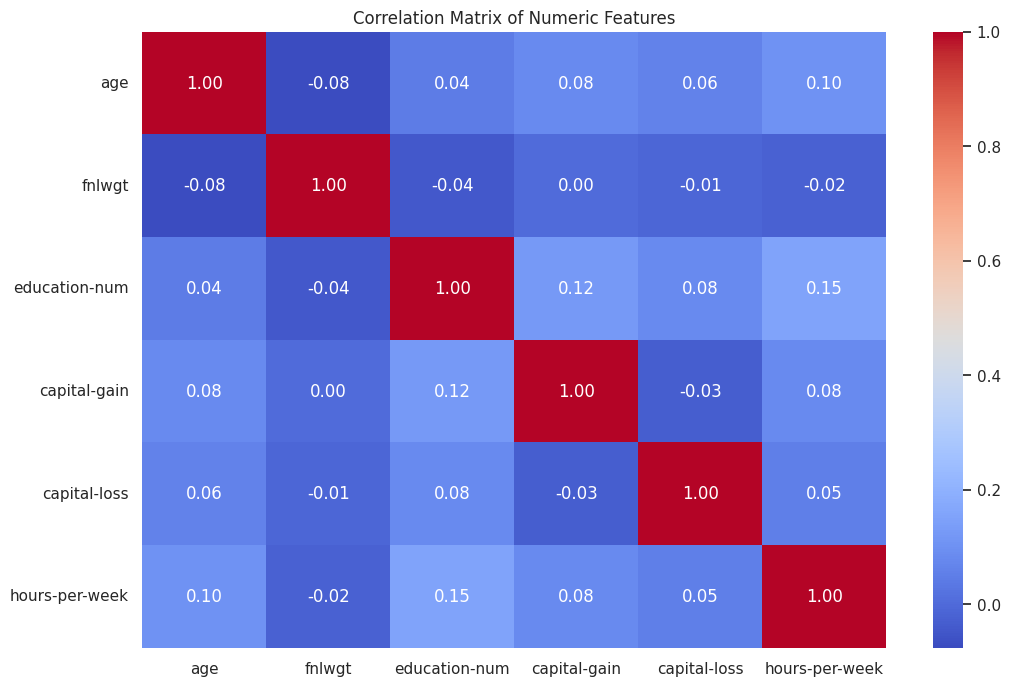

Class imbalance visualization



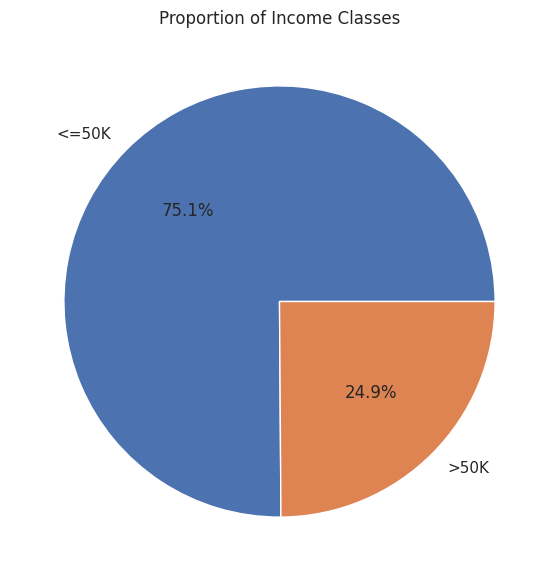

In [ ]:
#ESPLORATORY DATA ANALYSIS
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for better visibility
sns.set(style="whitegrid")

# Histograms for continuous features
print('Histograms for continuous features\n')
data[continuous_features].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.show()


# Count plots for categorical features
print('Count plots for categorical features\n')
fig, ax = plt.subplots(2, 4, figsize=(15, 6))  # Adjust shape according to number of categorical features
for var, subplot in zip(categorical_features[:-1], ax.flatten()):
    sns.countplot(data[var], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

# Exclude non-numeric columns and compute the correlation matrix
numeric_data = data.select_dtypes(include=[np.number])  # This only includes numeric columns
corr_matrix = numeric_data.corr()

# Plot the correlation matrix
print('Correlation matrix\n')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Pie chart for proportion of classes
print('Class imbalance visualization\n')
plt.figure(figsize=(7, 7))
data['income'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Income Classes')
plt.ylabel('')
plt.show()

This section applies Principal Component Analysis (PCA) to reduce the dataset's dimensionality to two principal components. This transformation is performed to visualize the data in a two-dimensional space, making it easier to observe how distinct the data clusters are with respect to the target variable 'income'. We then plot these two components, coloring the points based on the income categories, to visually assess the separability of the income classes in this reduced space.


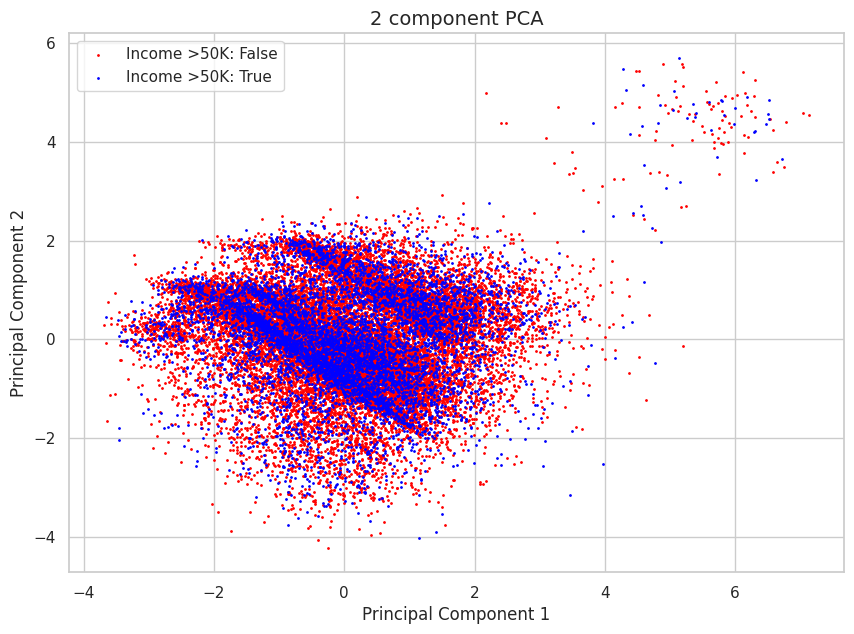

In [ ]:
#PCA VISUALIZATION
from sklearn.decomposition import PCA


# Encode categorical variables
data_cat = pd.get_dummies(data, columns=[col for col in categorical_features])

# Scale continuous features only
scaler = StandardScaler()
data_cat[continuous_features] = scaler.fit_transform(data_cat[continuous_features])

# Convert boolean columns to integer
for col in data_cat.columns:
    if data_cat[col].dtype == bool:
        data_cat[col] = data_cat[col].astype(int)

# Prepare features and labels before splitting
features = data_cat.drop(['income_<=50K', 'income_>50K'], axis=1)
labels = data_cat['income_>50K']


# Convert features to a numpy array if not already
features_array = features.values
labels_array = labels.values

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_array)


# Create DataFrames for the results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add the target variable to these dataframes for plotting
pca_df['Income'] = labels

# Plotting by income category
# Setup figure and axes
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

# Colors and income categories
colors = ['red', 'blue']
income_categories = [False, True]

# Plot PCA
for income, color in zip(income_categories, colors):
    indicesToKeep = pca_df['Income'] == income
    axes.scatter(pca_df.loc[indicesToKeep, 'PC1'],
                    pca_df.loc[indicesToKeep, 'PC2'],
                    c=color,
                    s=1,
                    label=f'Income >50K: {income}')
axes.set_xlabel('Principal Component 1', fontsize=12)
axes.set_ylabel('Principal Component 2', fontsize=12)
axes.set_title('2 component PCA', fontsize=14)
axes.legend(loc='best')
axes.grid(True)

# Display the plot
plt.show()

In this section, we preprocess the data by encoding categorical variables using one-hot encoding and scaling the continuous features to standardize the data, making it suitable for model training. We then split the data into training, validation, and test sets to ensure proper evaluation and validation of our models during training.
Due to class imbalance, we may apply oversampling techniques to the training data to improve model performance. We demonstrate how to use both SMOTE and Random Oversampling methods to balance the class distribution, which helps prevent our model from being biased toward the majority class. This dataset is not very imbalanced, but try experimenting a bit.


In [ ]:
#TRAIN TEST VALIDATION SPLIT, OVERSAMPLING

import torch
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler

def prepare_data(features_array, labels_array, oversample=False, oversample_type='smote'):
    # Split data into training and test sets first
    X_train_val, X_test, y_train_val, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)

    # Split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

    # Apply oversampling to the training data if requested
    if oversample:
        if oversample_type == 'smote':
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        elif oversample_type == 'random':
            ros = RandomOverSampler(random_state=42)
            X_train, y_train = ros.fit_resample(X_train, y_train)

    # Convert resampled training data, validation data, and test data to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = prepare_data(features_array,
                                                                                                        labels_array,
                                                                                                        oversample=False,
                                                                                                        oversample_type='smote')

Here, we establish benchmarks for our deep learning model by comparing its performance against traditional machine learning models: Logistic Regression and Random Forest. We first convert our tensors back to numpy arrays, which are required by Scikit-learn's API. After training each model on the training set, we evaluate them on the validation set to assess their accuracy and overall classification performance, including F1 scores. These benchmarks are crucial for understanding how well more complex models perform in comparison to more straightforward and interpretable models. Play with the model parameters to get the best performances on the validation set!


In [ ]:
#BENCHMARKS

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,  f1_score, precision_recall_curve, confusion_matrix


X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_test_np = X_test_tensor.numpy()
y_test_np = y_test_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

# Train Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_np, y_train_np)

# Train Random Forest
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=25)
random_forest_model.fit(X_train_np, y_train_np)

# Function to evaluate the classifier and find the best threshold for F1 score
def evaluate_classifier_for_best_threshold(classifier, X, y_true, y_scores=None, threshold=0):
    # Get the probability scores for the positive class
    if y_scores == None:
      y_scores = classifier.predict_proba(X)[:, 1]

    # Calculate precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2 * recall * precision / (recall + precision)
    # Find the index of the highest F1 score
    best_f1_index = np.argmax(f1_scores)
    if threshold == 0:
      best_threshold = thresholds[best_f1_index]
    else:
      best_threshold = threshold
    best_f1_score = f1_scores[best_f1_index]

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1 Score: {best_f1_score:.4f}")
    # Calculate accuracy and classification report using the best threshold
    y_pred = [1 if score >= best_threshold else 0 for score in y_scores]
    print(f"Accuracy:", accuracy_score(y_true, y_pred))
    print(f"Classification Report:\n", classification_report(y_true, y_pred, target_names=['<=50K', '>50K']))
    print(f"Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    return best_threshold, best_f1_score

# Evaluate the Logistic Regression classifier and find the best threshold
logistic_best_threshold, logreg_best_f1_score = evaluate_classifier_for_best_threshold(logistic_model, X_val_np, y_val_np)

# Evaluate the Random Forest classifier and find the best threshold
rf_best_threshold, rf_best_f1_score = evaluate_classifier_for_best_threshold(random_forest_model, X_val_np, y_val_np)



Best Threshold: 0.3899
Best F1 Score: 0.6992
Accuracy: 0.8458478368970661
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.90      0.89      0.90      4529
        >50K       0.68      0.72      0.70      1504

    accuracy                           0.85      6033
   macro avg       0.79      0.80      0.80      6033
weighted avg       0.85      0.85      0.85      6033

Confusion Matrix:
 [[4022  507]
 [ 423 1081]]
Best Threshold: 0.3918
Best F1 Score: 0.7175
Accuracy: 0.8538040775733466
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.89      0.90      4529
        >50K       0.69      0.74      0.72      1504

    accuracy                           0.85      6033
   macro avg       0.80      0.82      0.81      6033
weighted avg       0.86      0.85      0.86      6033

Confusion Matrix:
 [[4031  498]
 [ 384 1120]]


Here we define a Multilayer Perceptron (MLP) model using PyTorch. The MLP is a class of feedforward artificial neural network that consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. Each node, except for the input nodes, uses a nonlinear activation function. We'll use this model to classify individuals based on their income level. Try to modify the architecture, add more layers, change the activations, vary the number of neurons in each layer, include dropout(s) to prevent overfitting.


In [ ]:
#MODEL ARCHITECTURE DEFINITION AND INITIALIZATION
from torchsummary import summary

# Define MLP for classification
class MLP_Classifier(nn.Module):
    def __init__(self):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = MLP_Classifier().to(device)

#summary of model structure
summary(model, input_size=(X_train_tensor.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 18096, 64]           6,720
              ReLU-2            [-1, 18096, 64]               0
           Dropout-3            [-1, 18096, 64]               0
            Linear-4             [-1, 18096, 8]             520
              ReLU-5             [-1, 18096, 8]               0
            Linear-6             [-1, 18096, 1]               9
           Sigmoid-7             [-1, 18096, 1]               0
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 7.18
Forward/backward pass size (MB): 28.99
Params size (MB): 0.03
Estimated Total Size (MB): 36.20
----------------------------------------------------------------


In this section, we define an Early Stopping class to prevent overfitting during the training of our neural network. Early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. This class monitors the validation loss as the model trains, and if the loss does not improve after a specified number of epochs (defined by the 'patience' parameter), it stops the training. Additionally, the class saves the model at its best performance state, allowing us to revert to the best model after training concludes.


In [ ]:
#EARLY STOPPING

class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')



In this block, we handle the training process of our MLP model. Training is conducted over multiple epochs, where the model learns to predict the training data's outcomes accurately. We also utilize a validation set to monitor the model's performance and apply early stopping to prevent overfitting.

Epoch: 1, Training Loss: 0.7376, Validation Loss: 0.7091
Validation loss decreased (34.035937 --> 34.035937).  Saving model ...
Epoch: 2, Training Loss: 0.6556, Validation Loss: 0.5934
Validation loss decreased (34.035937 --> 28.485054).  Saving model ...
Epoch: 3, Training Loss: 0.5290, Validation Loss: 0.4790
Validation loss decreased (28.485054 --> 22.990515).  Saving model ...
Epoch: 4, Training Loss: 0.4438, Validation Loss: 0.4202
Validation loss decreased (22.990515 --> 20.170217).  Saving model ...
Epoch: 5, Training Loss: 0.4013, Validation Loss: 0.3901
Validation loss decreased (20.170217 --> 18.725911).  Saving model ...
Epoch: 6, Training Loss: 0.3790, Validation Loss: 0.3737
Validation loss decreased (18.725911 --> 17.936836).  Saving model ...
Epoch: 7, Training Loss: 0.3647, Validation Loss: 0.3633
Validation loss decreased (17.936836 --> 17.437014).  Saving model ...
Epoch: 8, Training Loss: 0.3555, Validation Loss: 0.3541
Validation loss decreased (17.437014 --> 16.998

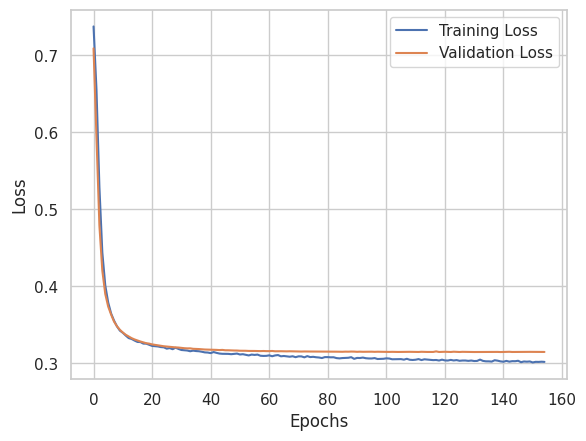

In [ ]:
#MODEL TRAINING

#hyperparameter
L2_reg = 0.0001
lr = 0.0001
batch_size = 128

#training parameters
patience = 25
epochs = 500

#training model function
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target.view(-1, 1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses

# Create TensorDatasets and DataLoaders for Training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Loss Function
class_counts = data_cat['income_>50K'].value_counts().sort_index().values
class_weights = [sum(class_counts) / c for c in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
#criterion = nn.BCELoss(weight=class_weights_tensor[0])
criterion = nn.BCELoss()

# Instantiate optimizer and early stopper
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=L2_reg)  # L2 Regularization
early_stopper = EarlyStopping(patience=patience)

# Run training and plot losses
train_losses, val_losses = train_model(epochs, model, optimizer, criterion, train_loader, test_loader, early_stopper)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Post-training, we evaluate the MLP model using the validation set to check its generalization capability. We compute various performance metrics like accuracy and F1 score, and visualize the results using a confusion matrix. This helps in understanding how well the model is performing and where it might be making errors. Go back and play with the model architecture and with the hyperparameters to find the best performing neural network.

In [ ]:
#EVALUATE MODEL ON VALIDATION SET

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve

# Function to evaluate the model and find the best threshold for F1 score
def evaluate_model(data_loader, model=model, threshold=0):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_scores = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_scores.extend(output.view(-1).cpu().numpy())  # Store raw model outputs
            y_true.extend(target.cpu().numpy())


    # Calculate precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2 * recall * precision / (recall + precision)
    # Find the index of the highest F1 score
    best_f1_index = np.argmax(f1_scores)
    if threshold == 0:
      best_threshold = thresholds[best_f1_index]
    else:
      best_threshold = threshold
    best_f1_score = f1_scores[best_f1_index]

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1 Score: {best_f1_score:.4f}")
    # Calculate accuracy and classification report using the best threshold
    y_pred = [1 if score >= best_threshold else 0 for score in y_scores]
    print("Multilayer Perceptron Accuracy:", accuracy_score(y_true, y_pred))
    print("Multilayer Perceptron Classification Report:\n", classification_report(y_true, y_pred, target_names=['<=50K', '>50K']))
    print("Multilayer Perceptron Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    return best_threshold, best_f1_score

# Call the function to evaluate the model and find the best threshold
mlp_best_threshold, mlp_best_f1_score = evaluate_model(val_loader)

Best Threshold: 0.3624
Best F1 Score: 0.7110
Multilayer Perceptron Accuracy: 0.8435272666998177
Multilayer Perceptron Classification Report:
               precision    recall  f1-score   support

       <=50K       0.92      0.87      0.89      4529
        >50K       0.66      0.77      0.71      1504

    accuracy                           0.84      6033
   macro avg       0.79      0.82      0.80      6033
weighted avg       0.85      0.84      0.85      6033

Multilayer Perceptron Confusion Matrix:
 [[3928  601]
 [ 343 1161]]


Finally, we compare the performance of our best MLP model against traditional machine learning models such as Logistic Regression and Random Forest. This comparison is crucial to evaluate the effectiveness of deep learning models against conventional approaches on this specific dataset. Use the test set only after having spent some time tuning the hyperparameters (also of the standard ML models) and the neural network architecture. **Once you test your models on the test set, you can't go back and modify them!**

In [ ]:
#COMPARE ALL MODELS ON TEST SET

# Predictions and Evaluations Logistic Model
print("--------------------------\nLOGISTIC MODEL\n--------------------------\n")
logistic_best_threshold, logistic_best_f1_score = evaluate_classifier_for_best_threshold(logistic_model,
                                                                                         X_test_np,
                                                                                         y_test_np,
                                                                                         threshold=logistic_best_threshold)

# Predictions and Evaluations Random Forest
print("\n--------------------------\nRANDOM FOREST\n--------------------------\n")
rf_best_threshold, rf_best_f1_score = evaluate_classifier_for_best_threshold(random_forest_model,
                                                                             X_test_np,
                                                                             y_test_np,
                                                                             threshold=rf_best_threshold)


# Predictions and Evaluations Multilayer Perceptron
print("\n--------------------------\nMULTILAYER PERCEPTRON\n--------------------------\n")
mlp_best_threshold, mlp_best_f1_score = evaluate_model(test_loader, threshold=mlp_best_threshold)



--------------------------
LOGISTIC MODEL
--------------------------

Best Threshold: 0.3899
Best F1 Score: 0.7006
Accuracy: 0.8410409414884801
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.90      0.89      0.89      4503
        >50K       0.68      0.71      0.69      1530

    accuracy                           0.84      6033
   macro avg       0.79      0.80      0.79      6033
weighted avg       0.84      0.84      0.84      6033

Confusion Matrix:
 [[3991  512]
 [ 447 1083]]

--------------------------
RANDOM FOREST
--------------------------

Best Threshold: 0.3918
Best F1 Score: 0.7234
Accuracy: 0.8534725675451682
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.89      0.90      4503
        >50K       0.70      0.75      0.72      1530

    accuracy                           0.85      6033
   macro avg       0.80      0.82      0.81      6033
weighted avg       

# BONUS: Model Ensembling

Leveraging the strengths of different models can lead to improved overall performance, especially for complex tasks. Each model may capture different patterns or relationships within the data, and by combining them, we can often achieve a more robust and accurate predictive system. MLPs are known for capturing complex patterns through their layers of abstraction, while Random Forests are praised for their stability and ability to reduce overfitting through averaging predictions over numerous decision trees.

In this section, we implement a strategy to merge the predictions from our trained Multilayer Perceptron (MLP) and Random Forest classifier. The key to this approach is to utilize the confidence of each model's predictions. For each data point, we compare the predicted probabilities (the model's certainty of its prediction) from both the MLP and the Random Forest. We then select the prediction from the model that exhibits higher confidence in its decision.


In [ ]:
#BONUS: MODEL ENSEMBLING
def combined_predictions(mlp_model, rf_model, X_mlp, X_rf):
    # Ensure the MLP model is in evaluation mode
    model.eval()

    # Get predictions for MLP
    with torch.no_grad():
        mlp_probs = torch.sigmoid(mlp_model(X_mlp)).cpu().numpy()

    # Get probabilities for Random Forest
    rf_probs = rf_model.predict_proba(X_rf)[:, 1]  # Probability for the positive class

    # Combine predictions by choosing the one with higher confidence
    combined_probs = []
    for i in range(len(X_rf)):
        # If the max probability from random forest is higher, use its prediction, else use MLP's
        if max(rf_probs[i], 1 - rf_probs[i]) > max(mlp_probs[i][0], 1 - mlp_probs[i][0]):
            combined_probs.append(rf_probs[i])
        else:
            combined_probs.append(mlp_probs[i][0])

    return combined_probs

# First run the combined predictions function on validation
combined_probs = combined_predictions(model, random_forest_model, X_val_tensor, X_val_np)

# Get best threshold on validation set
combined_best_threshold, combined_best_f1_score = evaluate_classifier_for_best_threshold(random_forest_model,
                                                                                         X_val_np,
                                                                                         y_val_np,
                                                                                         y_scores=combined_probs)

# Run the combined predictions function on test
combined_probs = combined_predictions(model, random_forest_model, X_test_tensor, X_test_np)

print("--------------------------\nCOMBINED MODEL\n--------------------------\n")

# Evaluate combined predictions on test set
combined_best_threshold, combined_best_f1_score = evaluate_classifier_for_best_threshold(model,
                                                                                         X_test_np,
                                                                                         y_test_np,
                                                                                         y_scores=combined_probs,
                                                                                         threshold=combined_best_threshold)



Best Threshold: 0.5559
Best F1 Score: 0.7166
Accuracy: 0.8549643626719708
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.89      0.90      4529
        >50K       0.70      0.74      0.72      1504

    accuracy                           0.85      6033
   macro avg       0.80      0.82      0.81      6033
weighted avg       0.86      0.85      0.86      6033

Confusion Matrix:
 [[4052  477]
 [ 398 1106]]
--------------------------
COMBINED MODEL
--------------------------

Best Threshold: 0.5559
Best F1 Score: 0.7244
Accuracy: 0.8564561577987734
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.90      0.90      4503
        >50K       0.71      0.74      0.72      1530

    accuracy                           0.86      6033
   macro avg       0.81      0.82      0.81      6033
weighted avg       0.86      0.86      0.86      6033

Confusion Matrix:
 [[4041  462]
 [